In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('new_data.csv').dropna(subset=['Text'])

print(len(df.index))
df['Text'].head()


91928


0    When the coworkers compliment you on how skinn...
1    Shape up this summer with @QLuxSpa! #waisttrai...
2    How to remove 400 #calories from your #diet wi...
3    Heartburn Acid Reflux &amp; GERD Diet Cure Wit...
4    David Zinczenko - the "Abs Diet" and "Zero Bel...
Name: Text, dtype: object

In [3]:
import preprocessor as p

df['clean_text'] = df['Text'].apply(lambda text: p.clean(str(text)))

df['clean_text'].head()

0    When the coworkers compliment you on how skinn...
1                          Shape up this summer with !
2              How to remove from your without effort?
3    Heartburn Acid Reflux &amp; GERD Diet Cure Wit...
4    David Zinczenko - the "Abs Diet" and "Zero Bel...
Name: clean_text, dtype: object

In [4]:
df.sort_values("Text", inplace = True)
# dropping ALL duplicte values
df.drop_duplicates(subset ="Text",keep = False, inplace = True)

In [5]:
df['clean_text'] = df['clean_text'].apply(lambda text: text.lower())

df['clean_text'].head()

34046                                     !dile a la ! ...
20327    " eating good , looking good , feeling good an...
84720            " fat kat, they call tht bitch garfield "
63664    " how are you going to exercise that decree wi...
53235      " i exercise at length so electrify the fence."
Name: clean_text, dtype: object

In [6]:
import re

def remove_contractions(text):
    text = re.sub(r'’', '\'', text)
    
    text = re.sub(r'won\'t', 'will not', text)
    text = re.sub(r'can\'t', 'can not', text)
    
    text = re.sub(r'\'s', ' is', text)
    text = re.sub(r'\'m', ' am', text)
    text = re.sub(r'\'re', ' are', text)
    text = re.sub(r'\'ve', ' have', text)
    text = re.sub(r'\'ll', ' will', text)
    text = re.sub(r'\'d', ' would', text)
    text = re.sub(r'\'t', ' not', text)
    text = re.sub(r'n\'t', ' not', text)
    
    return text

df['clean_text'] = df['clean_text'].apply(remove_contractions)

df['clean_text'].head()

34046                                     !dile a la ! ...
20327    " eating good , looking good , feeling good an...
84720            " fat kat, they call tht bitch garfield "
63664    " how are you going to exercise that decree wi...
53235      " i exercise at length so electrify the fence."
Name: clean_text, dtype: object

In [7]:
df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '')

df['clean_text'].head()

C:\Users\91958\AppData\Local\Temp\ipykernel_352\3609691566.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '')


34046                                          dile a la  
20327     eating good  looking good  feeling good and i...
84720                fat kat they call tht bitch garfield 
63664     how are you going to exercise that decree win...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [8]:
# Remove whitespaces.

df['clean_text'] = df['clean_text'].apply(lambda text: str(text).strip())

df['clean_text'].head()

34046                                            dile a la
20327    eating good  looking good  feeling good and it...
84720                 fat kat they call tht bitch garfield
63664    how are you going to exercise that decree wine...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [9]:
# Remove empty texts.

df = df.drop(df[df['clean_text'] == ''].index)

print(len(df.index))
df['clean_text'].head()

65003


34046                                            dile a la
20327    eating good  looking good  feeling good and it...
84720                 fat kat they call tht bitch garfield
63664    how are you going to exercise that decree wine...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [10]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\91958\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [11]:
# Remove non-English words.
from nltk.corpus import words
words = set(words.words())

df['clean_text'] = df['clean_text'].apply(lambda text: ' '.join(word for word in text.split() if word in words))

df['clean_text'].head()

34046                                                 a la
20327    eating good looking good feeling good and it i...
84720                              fat kat they call bitch
63664    how are you going to exercise that decree wine...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df['clean_text']))

In [14]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [15]:
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) 
   if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

In [16]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [17]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

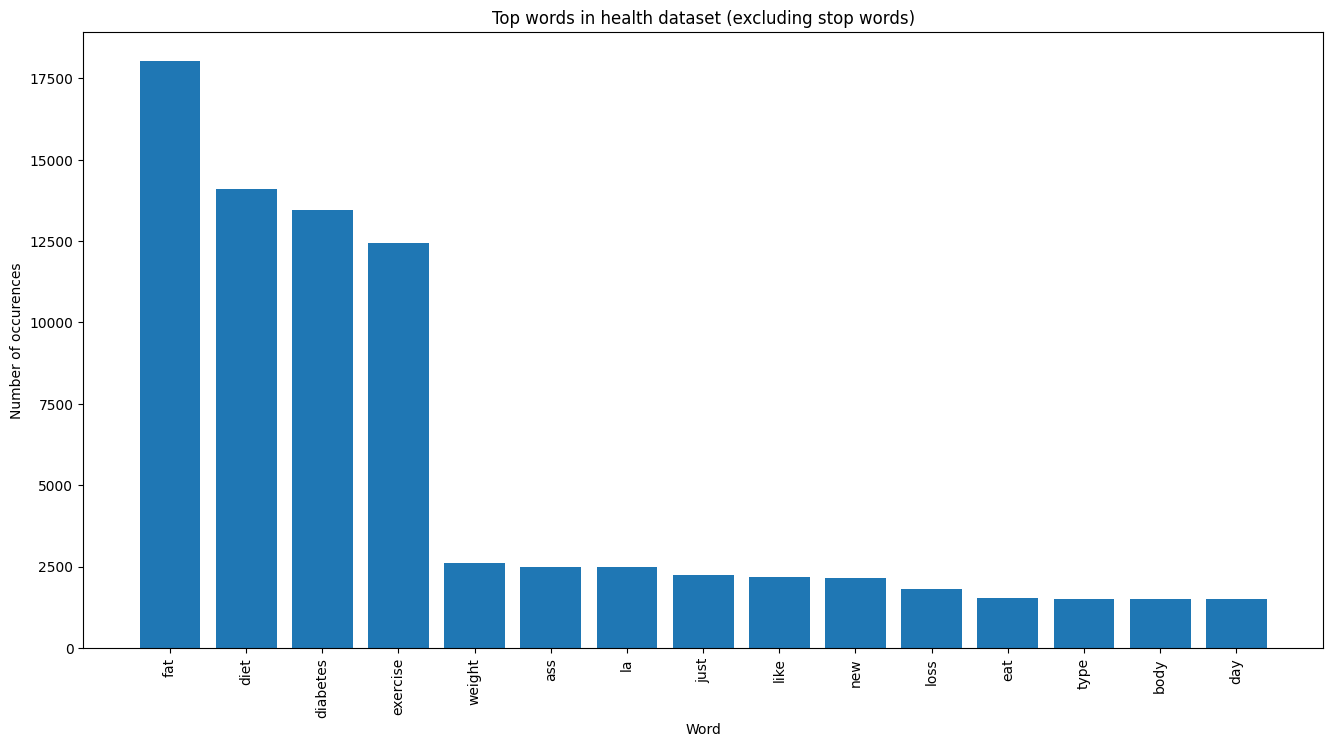

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in health dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [19]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[]


In [21]:
lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=corpus_tfidf, id2word=id2word, num_topics=20,chunksize=100
)

In [22]:
pprint(lsi_model.print_topics())
doc_lsi = lsi_model[corpus_tfidf]

[(0,
  '0.987*"diabetes" + 0.138*"diabete" + 0.033*"type" + 0.023*"get" + '
  '0.017*"association" + 0.017*"diet" + 0.015*"fat" + 0.014*"health" + '
  '0.012*"drug_meet" + 0.012*"reduce"'),
 (1,
  '0.908*"diet" + 0.307*"fat" + 0.120*"blood_pressure" + 0.113*"high" + '
  '0.082*"get" + 0.058*"weight" + 0.054*"eat" + 0.052*"lose" + 0.050*"loss" + '
  '0.049*"go"'),
 (2,
  '0.907*"fat" + -0.341*"diet" + 0.132*"get" + 0.101*"ass" + 0.058*"belly" + '
  '-0.048*"blood_pressure" + 0.047*"loss" + 0.044*"lose" + -0.040*"high" + '
  '0.036*"burn"'),
 (3,
  '0.976*"diabete" + -0.144*"diabetes" + 0.093*"type" + -0.051*"fat" + '
  '0.038*"heart_disease" + 0.035*"health" + -0.034*"diet" + '
  '0.033*"deadly_combination" + 0.030*"exercise" + 0.026*"cure"'),
 (4,
  '0.919*"exercise" + 0.195*"new" + 0.190*"version" + -0.096*"fat" + '
  '0.078*"get" + 0.072*"good" + 0.071*"weight" + -0.062*"diet" + '
  '0.062*"cleanup" + -0.057*"diabete"'),
 (5,
  '-0.511*"blood_pressure" + 0.476*"weight" + -0.454*"high

In [23]:
#print('\nPerplexity: ', lsi_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.37508829104463126


In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.lsimodel.LsiModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=data_lemmatized, start=2, limit=300, step=5)

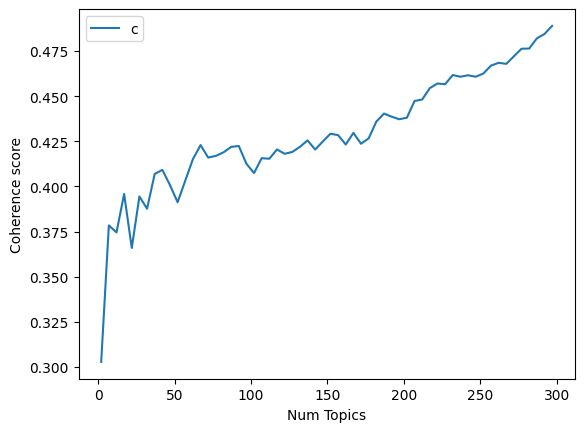

In [32]:
limit=300; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3027
Num Topics = 7  has Coherence Value of 0.3784
Num Topics = 12  has Coherence Value of 0.3745
Num Topics = 17  has Coherence Value of 0.3958
Num Topics = 22  has Coherence Value of 0.3659
Num Topics = 27  has Coherence Value of 0.3944
Num Topics = 32  has Coherence Value of 0.3876
Num Topics = 37  has Coherence Value of 0.4069
Num Topics = 42  has Coherence Value of 0.4091
Num Topics = 47  has Coherence Value of 0.4007
Num Topics = 52  has Coherence Value of 0.3912
Num Topics = 57  has Coherence Value of 0.4032
Num Topics = 62  has Coherence Value of 0.4151
Num Topics = 67  has Coherence Value of 0.4229
Num Topics = 72  has Coherence Value of 0.416
Num Topics = 77  has Coherence Value of 0.4169
Num Topics = 82  has Coherence Value of 0.4189
Num Topics = 87  has Coherence Value of 0.4219
Num Topics = 92  has Coherence Value of 0.4224
Num Topics = 97  has Coherence Value of 0.4125
Num Topics = 102  has Coherence Value of 0.4074
Num Topics = 10

In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.988*"diabetes" + 0.136*"diabete" + 0.032*"type" + 0.021*"get" + '
  '0.016*"association" + 0.016*"diet" + 0.014*"fat" + 0.013*"health" + '
  '0.013*"drug_meet" + 0.012*"reduce"'),
 (1,
  '0.927*"diet" + 0.270*"fat" + 0.117*"blood_pressure" + 0.110*"high" + '
  '0.069*"get" + 0.054*"weight" + 0.048*"eat" + 0.046*"lose" + 0.046*"go" + '
  '0.044*"loss"'),
 (2,
  '0.926*"fat" + -0.298*"diet" + 0.122*"get" + 0.102*"ass" + 0.047*"belly" + '
  '0.044*"loss" + 0.043*"lose" + -0.040*"blood_pressure" + 0.033*"body" + '
  '-0.033*"high"'),
 (3,
  '0.978*"diabete" + -0.141*"diabetes" + 0.087*"type" + -0.047*"fat" + '
  '0.035*"heart_disease" + 0.033*"health" + 0.031*"deadly_combination" + '
  '-0.030*"diet" + 0.027*"exercise" + 0.025*"get"'),
 (4,
  '0.939*"exercise" + 0.154*"version" + 0.151*"new" + -0.085*"fat" + '
  '0.079*"get" + 0.066*"good" + 0.065*"weight" + 0.062*"cleanup" + '
  '-0.056*"diet" + 0.049*"time"'),
 (5,
  '0.483*"weight" + -0.474*"blood_pressure" + -0.422*"high" + 0